## Predicting Yield Curve for future

Epoch [50/50], Loss: 0.0045


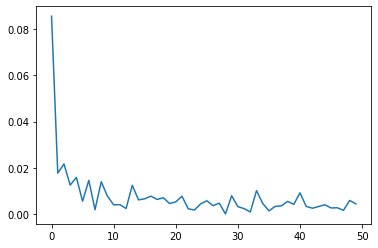

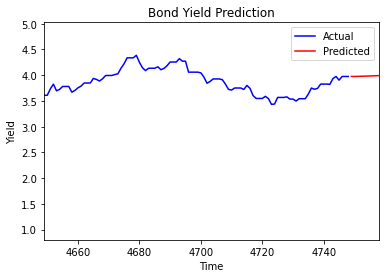

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Load data
df = pd.read_csv('bond_yields.csv')
df = df[df['sname']=='30Y US Bond'].reset_index(drop=True)

# Prepare data
x = df['value'].values
x = np.reshape(x, (-1, 1)).astype(np.float32)

# Normalize data
mean = np.mean(x)
std = np.std(x)
x = (x - mean) / std

# Define dataset class
class BondDataset(Dataset):
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_len]
        y = self.data[idx+self.seq_len]
        return x, y

# Define LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=16, num_layers=2):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Define training function
def train(model, dataloader, optimizer, criterion, epochs):
    loses = []
    for epoch in range(epochs):
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
        clear_output(wait=True)
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, loss.item()))
        loses.append(loss.item())
        plt.plot(loses)
        plt.show()

# Set hyperparameters
seq_len = 5
input_size = 1
hidden_size = 30
num_layers = 8
learning_rate = 0.001
batch_size = 32
epochs = 50

# Prepare data for training
dataset = BondDataset(x, seq_len)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model, loss function, and optimizer
model = LSTM(input_size, hidden_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train model
train(model, dataloader, optimizer, criterion, epochs)

# Prepare data for prediction
x_pred = x[-seq_len:]
x_pred = np.reshape(x_pred, (1, seq_len, input_size))
x_pred = torch.from_numpy(x_pred).to(device)

# Predict future values
model.eval()

# Denormalize data
x = x * std + mean

# Predict future values
model.eval()
with torch.no_grad():
    predictions = []
    for i in range(10):
        y_pred = model(x_pred).item()
        x_pred = torch.cat((x_pred[:, 1:, :], torch.tensor([[[y_pred]]]).to(device)), axis=1)
        predictions.append(y_pred)

# Denormalize predictions
predictions = np.array(predictions)
predictions = predictions * std + mean

# Plot actual values and predicted values
plt.plot(df['value'], color='blue', label='Actual')
plt.plot(range(len(df), len(df)+10), predictions, color='red', label='Predicted')
plt.xlim(df.index[-100], df.index[-1]+10)
plt.title('Bond Yield Prediction')
plt.xlabel('Time')
plt.ylabel('Yield')
plt.legend()
plt.show()

In [8]:
predictions

array([3.97579009, 3.97507869, 3.97705083, 3.97895305, 3.98096551,
       3.98298591, 3.98498511, 3.98705999, 3.98920745, 3.99143571])